# Qwen Vision Language Model (VLM) Tutorial

This notebook will guide you through using the Qwen2.5-VL model for multimodal tasks. The Qwen2.5-VL model can process both text and images, allowing for tasks like image captioning, visual question answering, and more.

## 1. Environment Setup

First, let's make sure we have all the necessary packages installed. We've already set up the environment using `uv`, but you can run this cell if you need to install any additional packages.

In [ ]:
# Uncomment and run if you need to install packages
# !uv pip install torch transformers jupyter pillow accelerate

## 2. Import Required Libraries

In [3]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

## 3. Load the Qwen2.5-VL Model

We'll load the Qwen2.5-VL-3B-Instruct model, which is fine-tuned for instruction following.

In [10]:
# Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto", attn_implementation="eager",
)

# Load the processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.


In [5]:
model.device

device(type='mps', index=0)

### 3.1 Advanced Model Loading (Optional)

For better performance, you can enable flash attention 2. This is especially useful for multi-image and video scenarios.

In [ ]:
# Uncomment to use flash attention 2 for better performance
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

### 3.2 Custom Processor Configuration (Optional)

You can customize the processor to control the number of visual tokens per image.

In [ ]:
# Uncomment to customize the processor
# min_pixels = 256*28*28  # Minimum number of pixels
# max_pixels = 1280*28*28  # Maximum number of pixels
# processor = AutoProcessor.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct", 
#     min_pixels=min_pixels, 
#     max_pixels=max_pixels
# )

## 4. Helper Functions for Visualization

In [11]:
def display_image(image_url):
    """Display an image from a URL"""
    if image_url.startswith('http'):
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(image_url)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img

def generate_response(messages):
    """Generate a response from the model given messages"""
    # Prepare for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    # Generate the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

## 5. Example 1: Image Description

Let's start with a simple example: asking the model to describe an image.

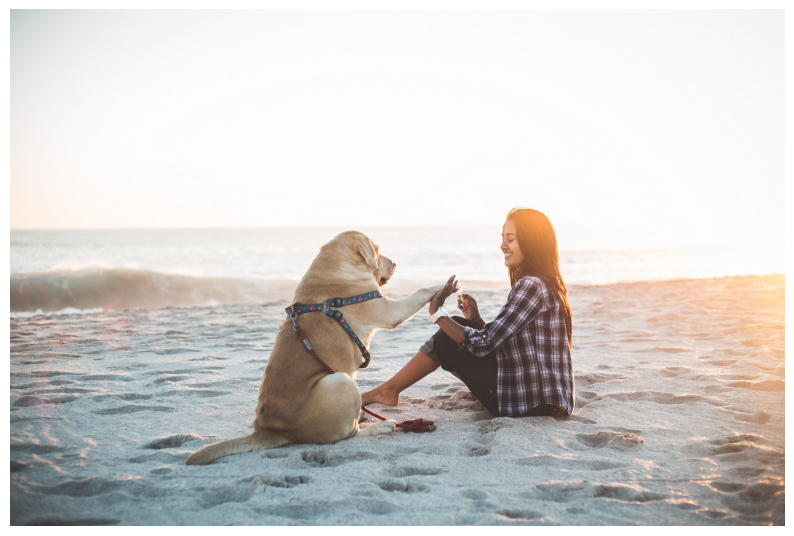

In [12]:
# Example image URL
image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"

# Display the image
img = display_image(image_url)

In [13]:
# Create messages for image description
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_url,
            },
            {"type": "text", "text": "Describe this image in detail."},
        ],
    }
]

# Generate and print the response
response = generate_response(messages)
print(response)

RuntimeError: MPS backend out of memory (MPS allocated: 14.38 GB, other allocations: 6.81 MB, max allowed: 18.13 GB). Tried to allocate 6.10 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## 6. Example 2: Visual Question Answering

Now let's try asking specific questions about an image.

In [ ]:
# Create messages for visual question answering
vqa_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_url,
            },
            {"type": "text", "text": "What animals can you see in this image?"},
        ],
    }
]

# Generate and print the response
response = generate_response(vqa_messages)
print(response)

## 7. Example 3: Using a Local Image

You can also use local images with the model. First, you'll need to download an image or use one you already have.

In [ ]:
# Download an example image
!curl -o sample_image.jpg https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg

In [ ]:
# Display the local image
local_img = display_image("sample_image.jpg")

In [ ]:
# Create messages using the local image
local_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "sample_image.jpg",
            },
            {"type": "text", "text": "What is the main color of the background?"},
        ],
    }
]

# Generate and print the response
response = generate_response(local_messages)
print(response)

## 8. Example 4: Multi-turn Conversation

The model can also handle multi-turn conversations about images.

In [ ]:
# Start a conversation
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_url,
            },
            {"type": "text", "text": "What's in this image?"},
        ],
    }
]

# First response
response1 = generate_response(conversation)
print("Model:", response1)

# Add the model's response to the conversation
conversation.append({"role": "assistant", "content": response1})

# Add a follow-up question
conversation.append({"role": "user", "content": "Can you count how many animals are there?"})

# Get the model's response to the follow-up
response2 = generate_response(conversation)
print("\nUser: Can you count how many animals are there?")
print("Model:", response2)

## 9. Example 5: Multiple Images

The model can also process multiple images in a single conversation.

In [ ]:
# Download a second image
!curl -o sample_image2.jpg https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct/resolve/main/assets/demo2.jpg

In [ ]:
# Display the second image
img2 = display_image("sample_image2.jpg")

In [ ]:
# Create messages with multiple images
multi_image_messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Compare these two images:"},
            {"type": "image", "image": "sample_image.jpg"},
            {"type": "image", "image": "sample_image2.jpg"},
        ],
    }
]

# Generate and print the response
response = generate_response(multi_image_messages)
print(response)

## 10. Advanced: Customizing Generation Parameters

You can customize the generation parameters to control the output.

In [ ]:
def generate_with_params(messages, max_new_tokens=128, temperature=0.7, top_p=0.9):
    """Generate a response with custom parameters"""
    # Prepare for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    # Generate with custom parameters
    generated_ids = model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=True
    )
    
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

In [ ]:
# Create messages for creative generation
creative_messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_url,
            },
            {"type": "text", "text": "Write a short story inspired by this image."},
        ],
    }
]

# Generate with different parameters
print("=== More Creative (Higher Temperature) ===")
creative_response = generate_with_params(creative_messages, temperature=1.0, max_new_tokens=200)
print(creative_response)

print("\n=== More Focused (Lower Temperature) ===")
focused_response = generate_with_params(creative_messages, temperature=0.3, max_new_tokens=200)
print(focused_response)

## 11. Conclusion

In this notebook, we've explored how to use the Qwen2.5-VL model for various multimodal tasks:

1. Image description
2. Visual question answering
3. Using local images
4. Multi-turn conversations
5. Processing multiple images
6. Customizing generation parameters

The Qwen2.5-VL model is a powerful tool for multimodal tasks, capable of understanding both text and images to generate meaningful responses. You can explore more advanced use cases and fine-tuning options in the [official documentation](https://github.com/QwenLM/Qwen2.5).